In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yfin
yfin.pdr_override()
import StockPull
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM

import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras import layers

#load data
company = 'tsla'
start = dt.datetime(2012,1,1)
end = dt.datetime(2022,1,1)
#
# start = "2012-01-01 00:00:00"
# end = "2020-01-01 00:00:00"

data = StockPull.analysisout(company)
# data = pdr.get_data_yahoo(company, 'yahoo', start, end)

#prepare data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [7]:

#build the model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1)) #prediction of the next closing value)

model.compile(optimizer ='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



Epoch 1/25
38/38 [==============================] - 4s 25ms/step - loss: 0.0251
Epoch 2/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0033
Epoch 3/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0030
Epoch 4/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0028
Epoch 5/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0024
Epoch 6/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0023
Epoch 7/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0026
Epoch 8/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0024
Epoch 9/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0025
Epoch 10/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0020
Epoch 11/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0021
Epoch 12/25
38/38 [==============================] - 1s 26ms/step - loss: 0.0019
Epoch 13/25
38/38 [==================

In [8]:
#TEST THE MODEL ACCURACY

test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()

# test_data = pdr.get_data_yahoo(company, 'yahoo', test_start, test_end)
test_data = StockPull.analysisout(company, '5y','1d')
actual_prices = test_data ['Price'].values

total_dataset = pd.concat((data['Price'], test_data['Price']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inpts = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inpts)


In [9]:
#makeprediction on test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


40/40 [==============================] - 1s 9ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


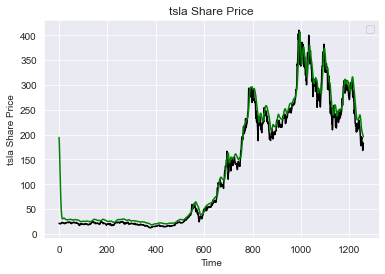

In [10]:
#plot the test predictions
plt.plot(actual_prices, color = "black")
plt.plot(predicted_prices, color = "green")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()


In [11]:
#Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction =  model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 1s 604ms/step
Prediction: [[194.03638]]
